# Gallery of Centrality

Here are some centrality algorithms with pygraphblas.  The first few graphs are of the Zachary Karate graph, and the benchmarks at the end benchmark numerious large SNAP graphs with these algorithms.

## Karate Graph

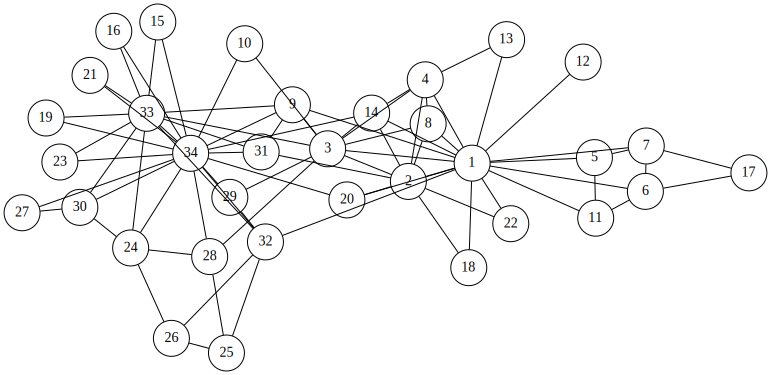

In [7]:
from timeit import repeat
from pygraphblas import *
from pygraphblas.gviz import *
from random import sample

karate = dict(Matrix.ssget('Newman/karate'))['karate.mtx'].cast(FP32)

# get one-based lables
labels1 = karate.cast(INT64).positioni1().reduce_vector(INT64.any_monoid)
draw_graph(karate, directed=False, show_weight=False, label_vector=labels1, label_width=5, graph_attr=dict(layout='sfdp'))

## Degree Centrality

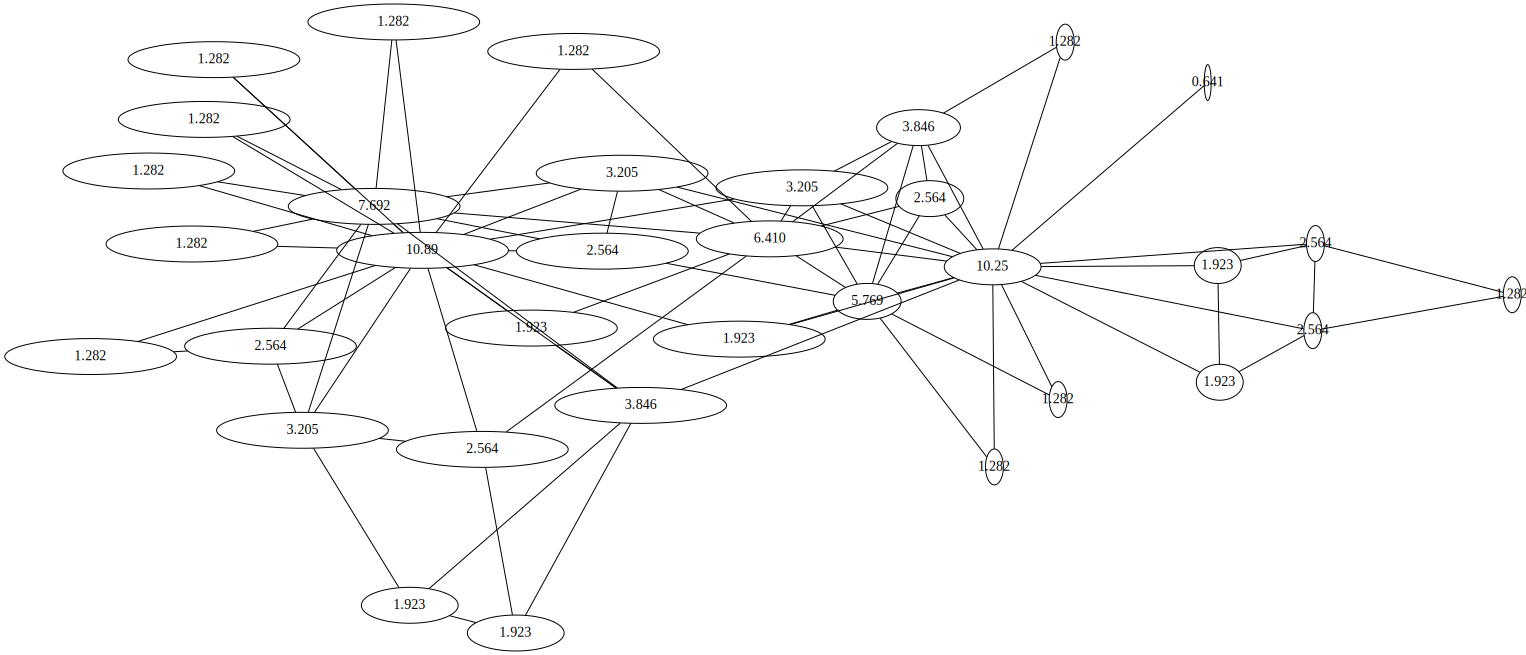

In [8]:
def DC(A):
    v = Vector.dense(A.type, A.nrows, 1.0)
    with FP64.PLUS_PAIR:
        return (A @ v) / A.nvals

dc = DC(karate) * 100
draw_graph(karate, directed=False, label_vector=dc, size_vector=dc, size_scale=1, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

## PageRank

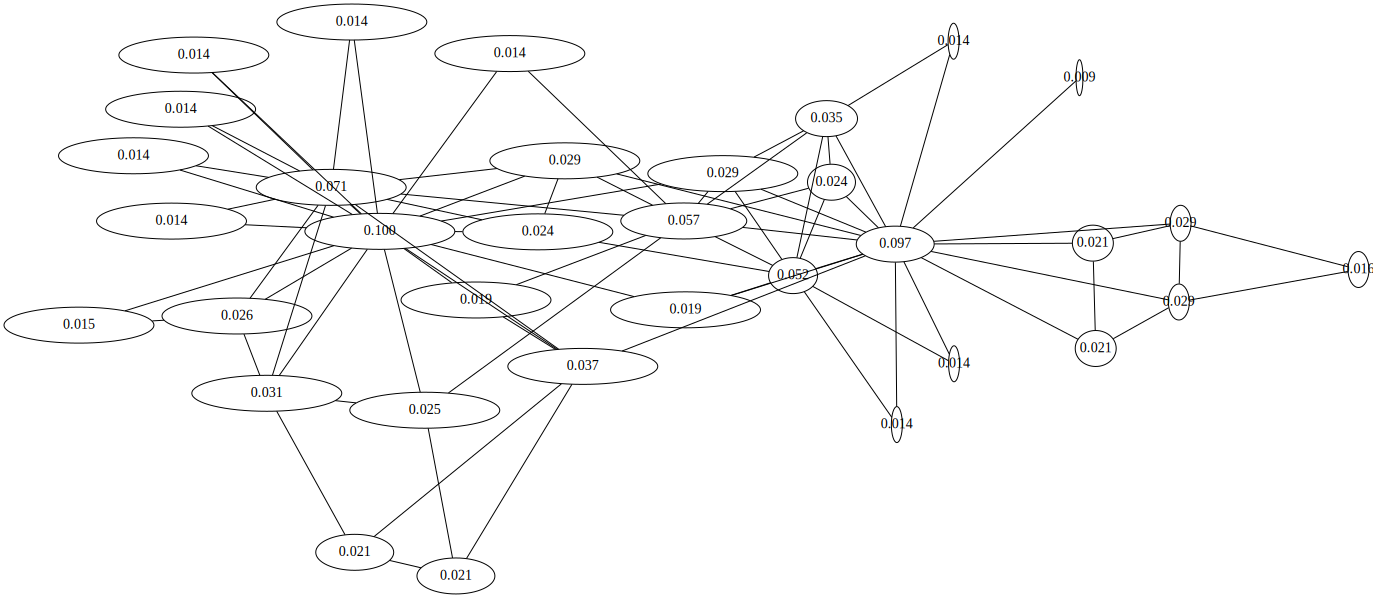

In [9]:
def PR(A, damping, itermax):
    n = A.nrows
    r = Vector.sparse(FP32, n)
    t = Vector.sparse(FP32, n)
    d = A.reduce_vector()
    d.assign_scalar(damping, accum=FP32.DIV)
    r[:] = 1.0 / n
    teleport = (1 - damping) / n
    tol = 1e-4
    rdiff = 1.0
    for i in range(itermax):
        # swap t and r
        temp = t ; t = r ; r = temp
        w = t / d
        r[:] = teleport
        A.mxv(w, out=r, accum=FP32.PLUS, semiring=FP32.PLUS_SECOND,
              desc=descriptor.T0)
        t -= r
        t.apply(FP32.ABS, out=t)
        rdiff = t.reduce_float()
        if rdiff <= tol:
            break
    return r

pr = PR(karate, 0.85, 100)
draw_graph(karate, directed=False, label_vector=pr, size_vector=pr, size_scale=80, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

## Triangle Centrality

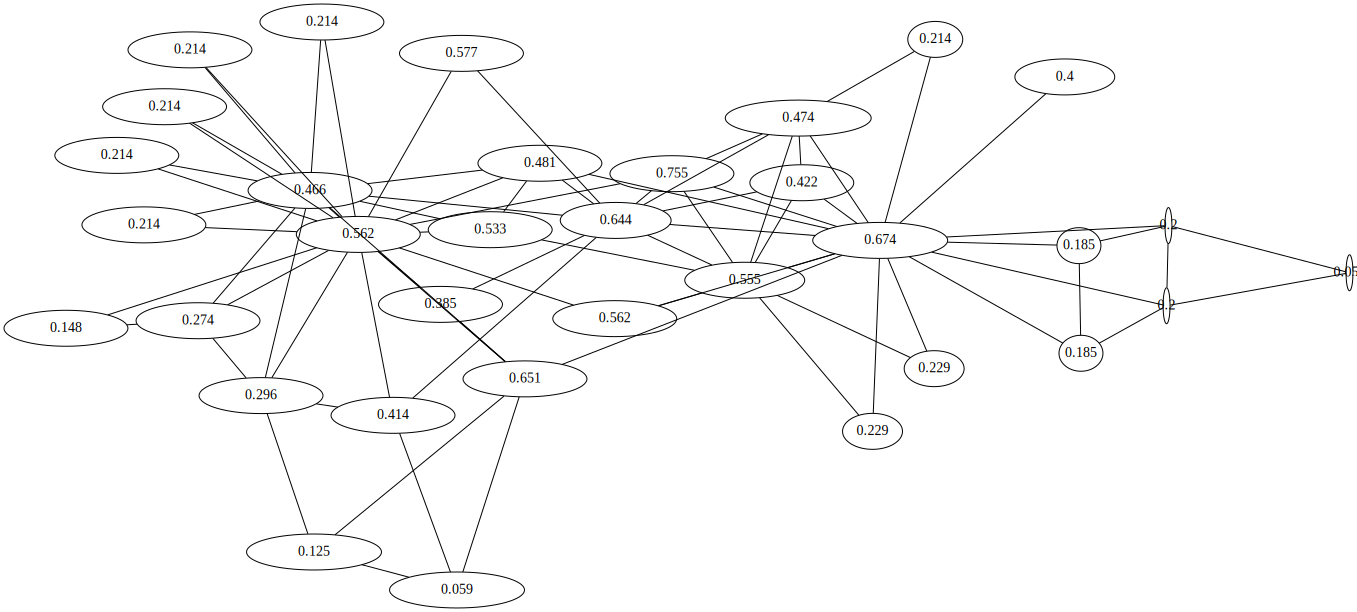

In [10]:
def TC(A):
    T = A.mxm(A, mask=A)
    y = T.reduce_vector()
    k = y.reduce_float()
    return (1/k) * (3 * (A @ y) - 2 * T.mxv(y, semiring=FP64.PLUS_SECOND) + y)

tc = TC(karate)
draw_graph(karate, directed=False, label_vector=tc, size_vector=tc, size_scale=10, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

## Betweenness Centrality

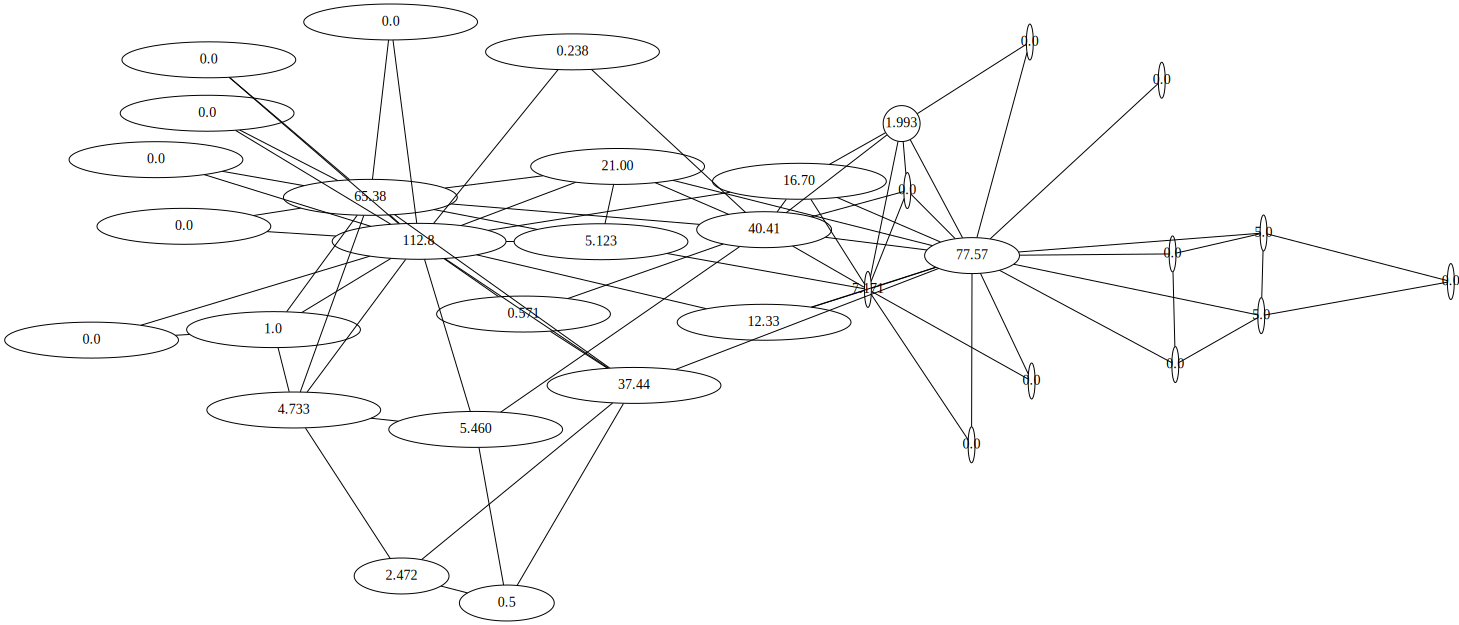

In [11]:
def BC(A, sources=None, k=100):
    if sources is None:
        sources = sample(list(A.rows), min(k, A.nrows))
    AT = A.T
    n = A.nrows
    ns = len(sources)
    paths      = Matrix.dense (FP32, ns, n, 0)
    frontier   = Matrix.sparse(FP32, ns, n)
    S = []

    for i, s in enumerate(sources):
        paths[   i, sources[i]] = 1
        frontier[i, sources[i]] = 1

    frontier.mxm(
        A,
        out=frontier,
        mask=paths,
        semiring=FP32.PLUS_FIRST,
        desc=descriptor.RC)

    for depth in range(n):
        if frontier.nvals == 0:
            break
        s = Matrix.sparse(BOOL, ns, n)
        frontier.apply(BOOL.ONE, out=s)
        S.append(s)
        paths.assign_matrix(frontier, accum=FP32.PLUS)
        frontier.mxm(A,
            out=frontier,
            mask=paths,
            semiring=FP32.PLUS_FIRST,
            desc=descriptor.RC)

    bc = Matrix.dense(FP32, ns, n, 1)
    W = Matrix.sparse(FP32, ns, n)

    for i in range(depth - 1, 0, -1):
        bc.emult(paths, FP32.DIV,
                 out=W,
                 mask=S[i],
                 desc=descriptor.R)
        W.mxm(AT, out=W,
              mask=S[i-1],
              semiring=FP32.PLUS_FIRST,
              desc=descriptor.R)
        W.emult(paths, FP32.TIMES,
                out=bc,
                accum=FP32.PLUS)

    centrality = Vector.dense (FP32, n, -ns)
    bc.reduce_vector(accum=FP32.PLUS,
                     out=centrality,
                     desc=descriptor.T0)
    return centrality

bc = BC(karate, k=10)
draw_graph(karate, directed=False, label_vector=bc, size_vector=bc, size_scale=0.1, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

## Benchmarks

Several graphs are benchmarked across all centrality algorithms.

In [ ]:
from collections import defaultdict
from pathlib import Path
from random import seed

graphs = [
    # ('Newman/karate', -1),
    ('SNAP/wiki-Vote', -1),
    # ('SNAP/com-Amazon', 0),
    # ('SNAP/com-Youtube', -1),
    # ('SNAP/as-Skitter', -1),
    # ('SNAP/com-LiveJournal', -1),
    # ('SNAP/com-Orkut', -1),
    # ('SNAP/com-Friendster', -1)
]

algorithms = [(DC, (), 42), 
              (PR, (0.85, 10), 42),
              (BC, (None, 10), 42),
              (TC, (), 42),
             ]

here = Path('.')

results = defaultdict(dict)
R = 3
N = 1
for name, offset in graphs:
    print(f'Loading {name}')
    G = list(Matrix.ssget(name, binary_cache_dir=here))[offset][1]
    print(f'{name} has {G.nvals} edges')
    for f, args, random_seed in algorithms:
        fname = f.__name__
        print(f'Running {fname} {args} on {name} {R} times')
        seed(random_seed)
        result = repeat(f'{fname}(G, *args)', repeat=R, number=N, globals=locals())
        avg = sum(result) / len(result)
        print(f'{fname} on {name} took ', avg, f'average for {R} runs')
        results[name][fname] = avg

results

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = []

width = 0.5  # the width of the bars
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [50, 25]

for name, runs in results.items():
    for a, times in runs.items():
        label = name + '-' + a
        ax.bar(label, times, width, label=label)
        labels.append(label)

ax.set_ylabel('Time (log)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.yscale('log')
plt.show()
